#### ML Modeling

In [1]:
import pandas as pd

# 사용할 모델
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from freeman.plt_setting import plt_settings
from freeman.evaluation import regression_evaluation, f_importances, plot_actual_pred
from freeman.aiddd.data_manager import read_data

plt_settings()

In [2]:
df_X = read_data('2a-sub-scaled-X1', process_seq='4th')
df_y = read_data('2a-sub-y1', process_seq='4th')

In [3]:
training_columns = df_X.columns

X_train, X_test, y_train, y_test = \
    train_test_split(df_X, df_y, test_size=0.2)
    
X_test_copy = X_test.copy()

In [4]:
SEED = 123
ml_models = {
    'LIN': LinearRegression(),
    'LASSO': Lasso(),
    'RIDGE': Ridge(),
    'KNR': KNeighborsRegressor(),
    'DTR': DecisionTreeRegressor(),
    'RFR': RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=SEED),
    'GBR': GradientBoostingRegressor(),
    'EN': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=SEED),
    'XGR': XGBRegressor(eta=0.01, n_estimators=100, n_jobs=-1),
}

In [5]:
def diff_ytest_pred(model_key, test, pred):
    test = test['total_cons_cost'].values.tolist()
    pred = pred.tolist()
    if isinstance(pred[0], list):
        pred = [item for sub in pred for item in sub]
    max_test = max(test)
    loop_size = len(test)
    result_mape = []
    result_max_mape = []
    for idx in range(loop_size):
        new_mape = abs((test[idx] - pred[idx])/test[idx])*100
        new_max_mape = abs((test[idx] - pred[idx])/(test[idx]+max_test))*100
        result_mape.append(new_mape)
        result_max_mape.append(new_max_mape)
    X_test_copy[f'{model_key}_mape'] = result_mape
    X_test_copy[f'{model_key}_max_mape'] = result_max_mape

In [6]:
def model_fit_and_evaluation(model_key, display_start=0, display_size=50):
    model = ml_models[model_key]
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(f'Evaluation: {model_key}')
    evaluation_value = regression_evaluation(y_test, predictions)
    evaluation_values.append(evaluation_value)
    model_names.append(model_key)
    diff_ytest_pred(model_key, y_test, predictions)
    try:
        f_importances(model, training_columns, model_key)
    except AttributeError as e:
        print(f'`{model_key}` object has no attribute `feature_importances_`')
    plot_actual_pred(
        y_test[display_start:display_start+display_size],
        predictions[display_start:display_start+display_size],
        model_key
    )

Evaluation: LIN
R2_SCORE: 0.436293, MAPE: 20.122773, MSE: 3274344233132.935547, RMSE: 1809514.916527, MAE: 809564.890005
`LIN` object has no attribute `feature_importances_`


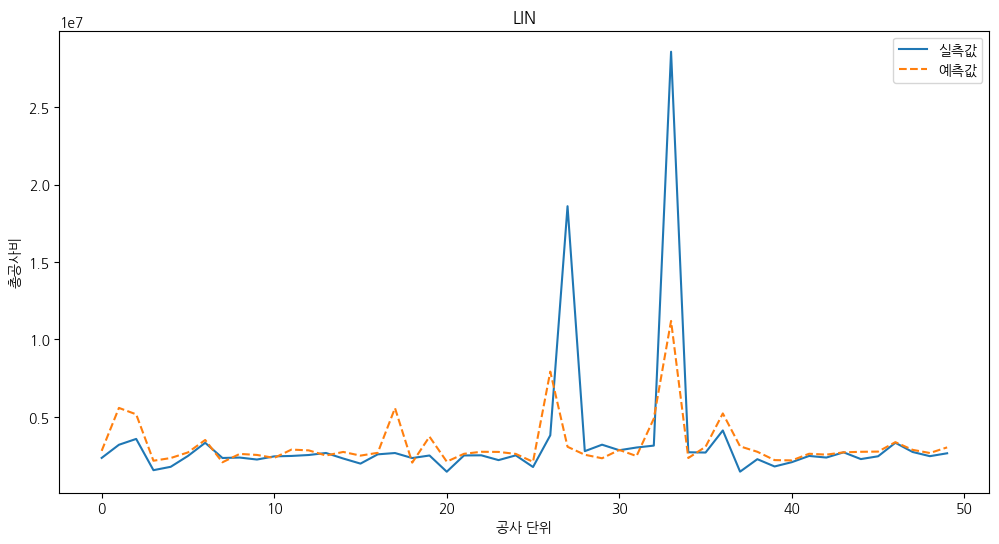

/home/freeman/anaconda3/envs/t213p310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.658e+15, tolerance: 2.447e+12
  model = cd_fast.enet_coordinate_descent(


Evaluation: LASSO
R2_SCORE: 0.436328, MAPE: 20.122314, MSE: 3274141424271.048340, RMSE: 1809458.876093, MAE: 809537.825752
`LASSO` object has no attribute `feature_importances_`


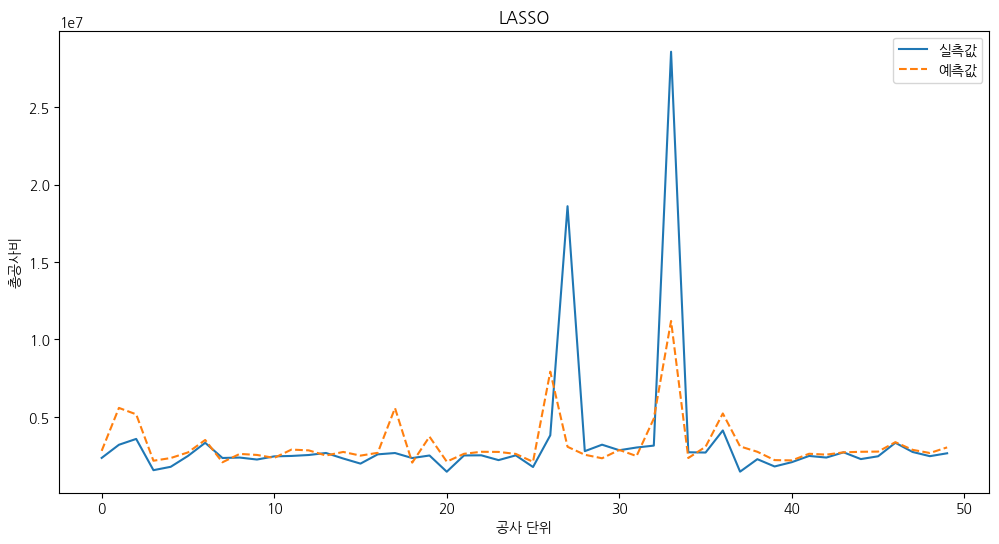

Evaluation: RIDGE
R2_SCORE: 0.436436, MAPE: 20.119921, MSE: 3273512509249.425781, RMSE: 1809285.082360, MAE: 809450.657877
`RIDGE` object has no attribute `feature_importances_`


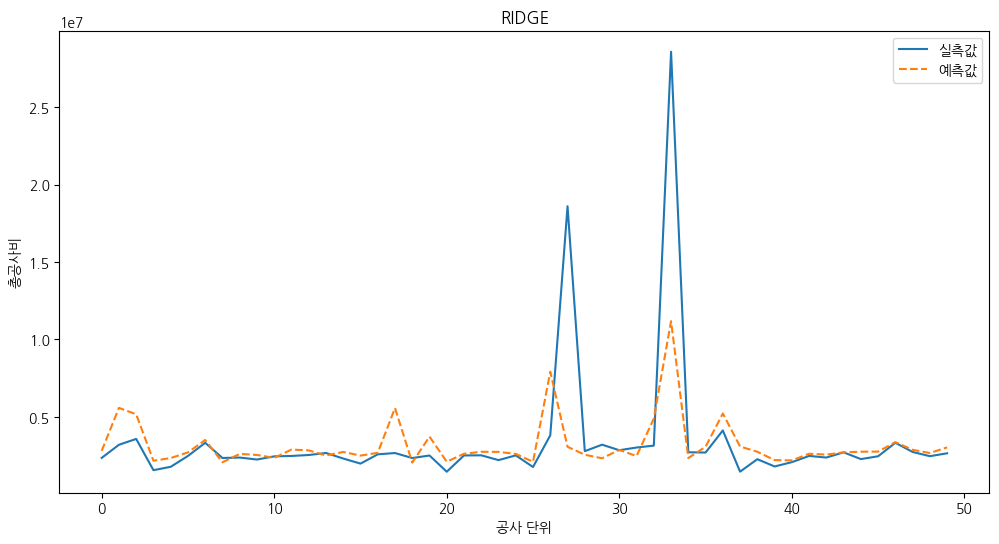

Evaluation: KNR
R2_SCORE: 0.339765, MAPE: 19.578645, MSE: 3835035431256.479980, RMSE: 1958324.649096, MAE: 821673.262050
`KNR` object has no attribute `feature_importances_`


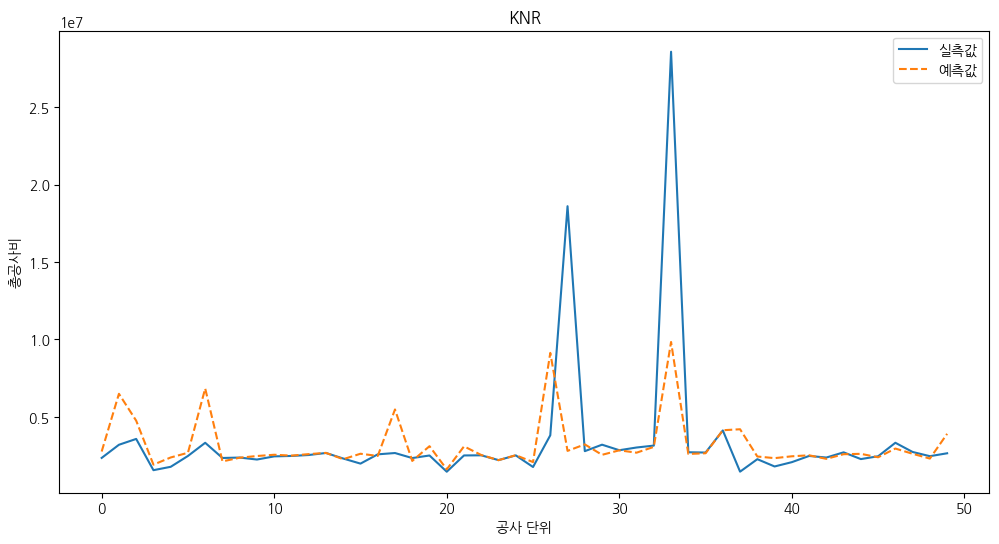

Evaluation: DTR
R2_SCORE: -0.065211, MAPE: 24.655159, MSE: 6187376823997.172852, RMSE: 2487443.833335, MAE: 996235.843177


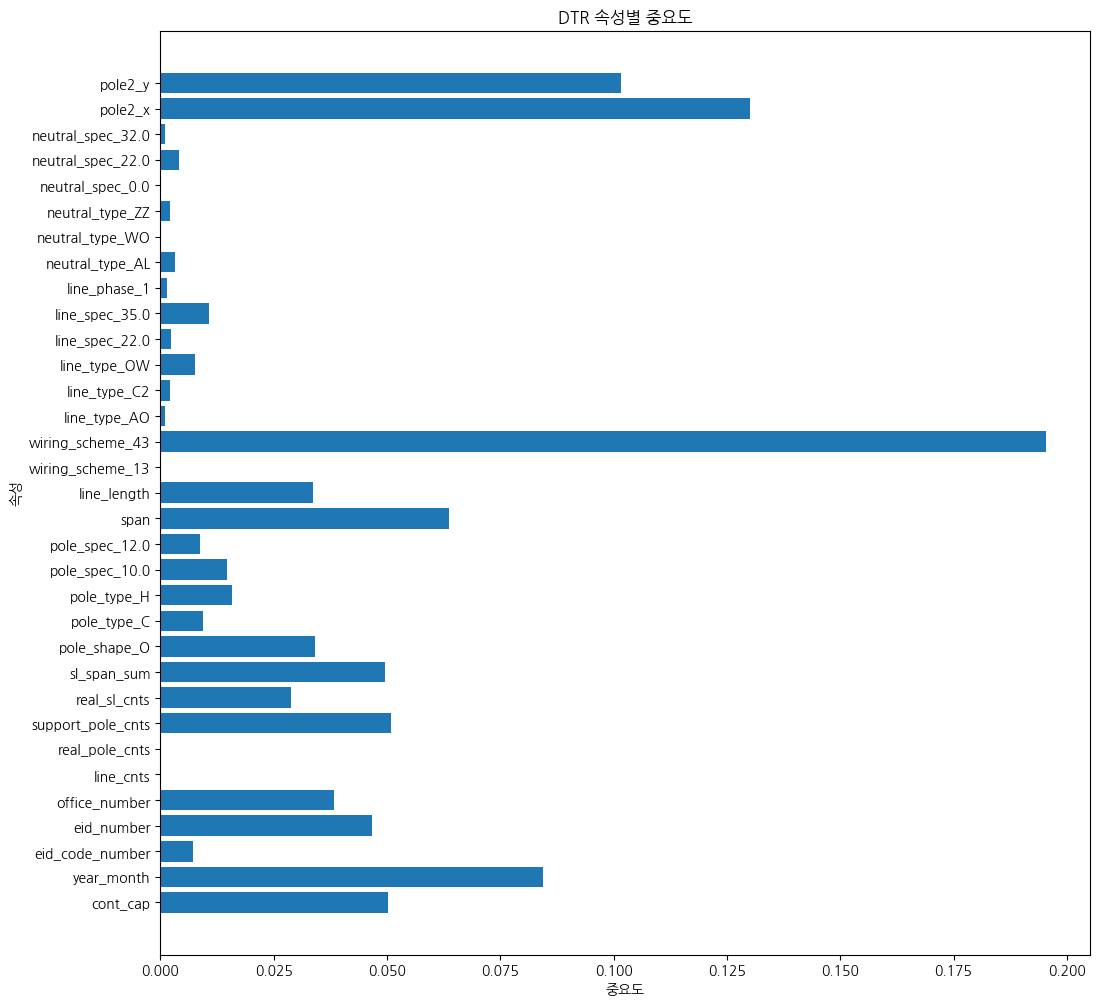

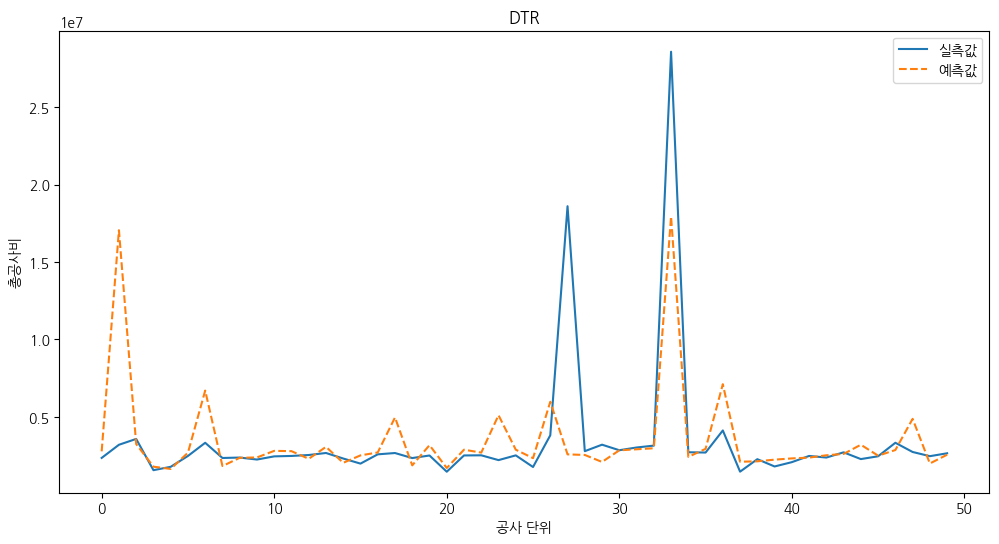

/home/freeman/anaconda3/envs/t213p310/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Evaluation: RFR
R2_SCORE: 0.379955, MAPE: 20.197340, MSE: 3601586552122.273438, RMSE: 1897784.643241, MAE: 826995.939582


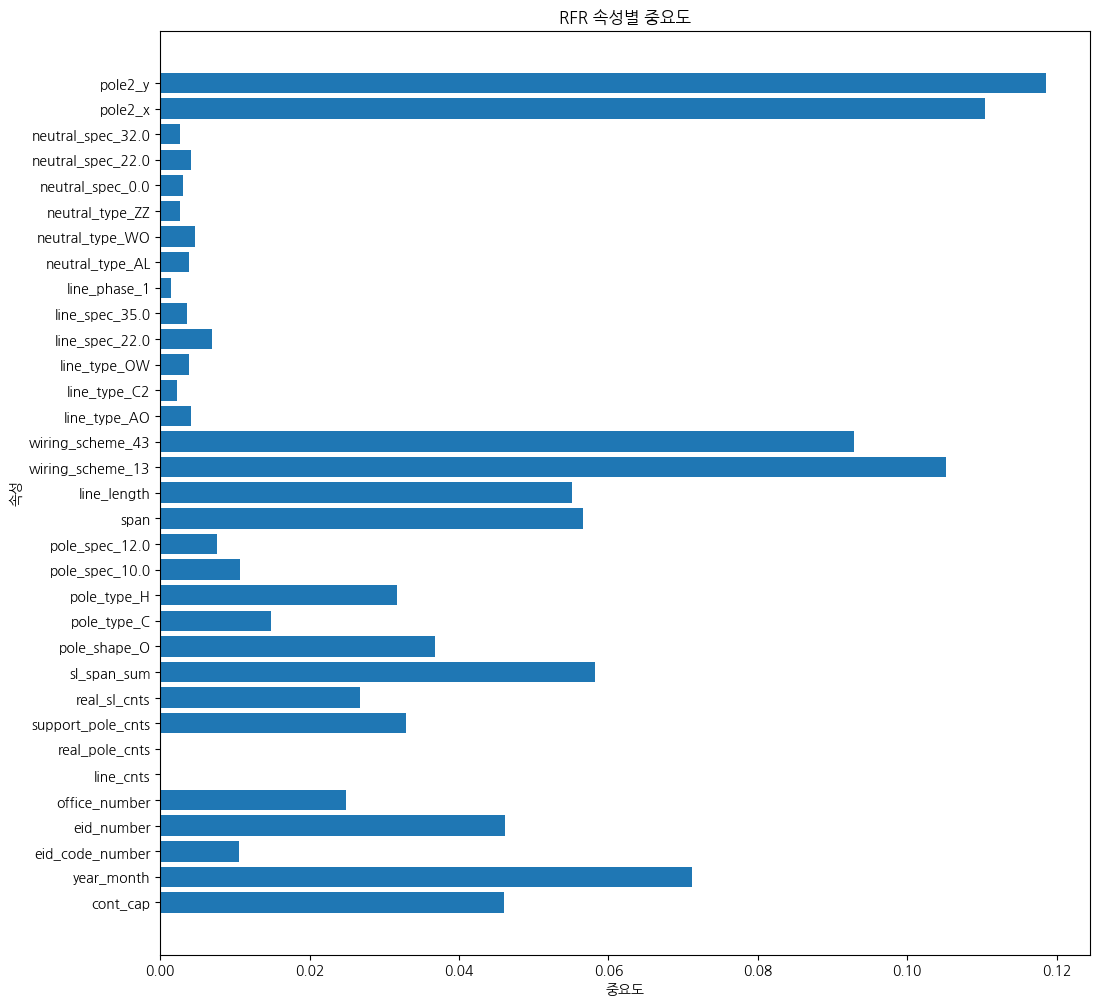

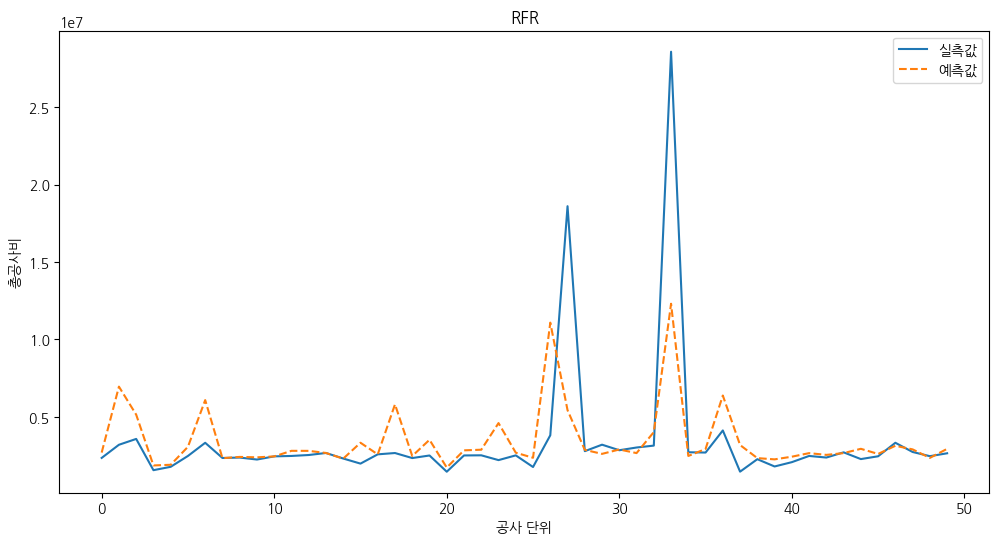

/home/freeman/anaconda3/envs/t213p310/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluation: GBR
R2_SCORE: 0.421536, MAPE: 19.146132, MSE: 3360064357730.643066, RMSE: 1833047.832909, MAE: 786318.952176


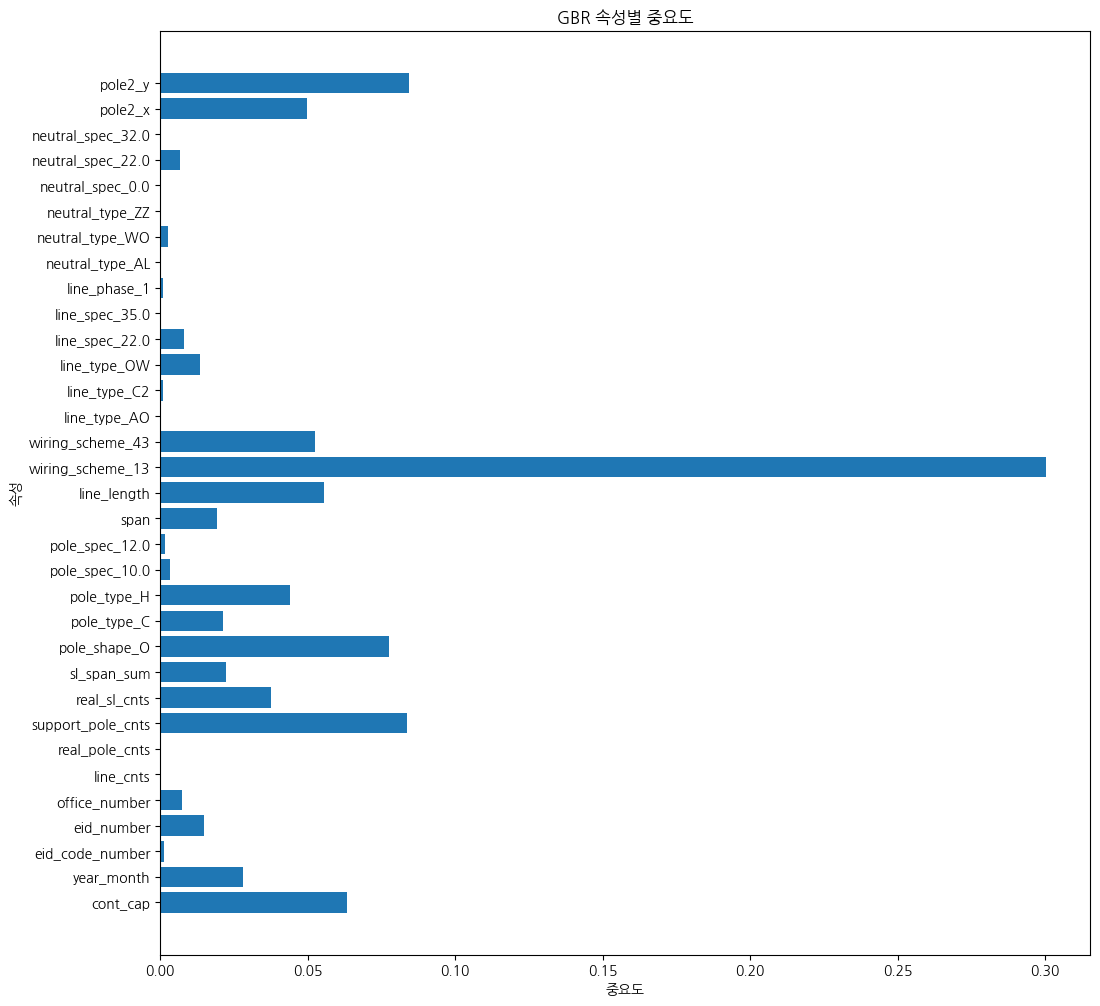

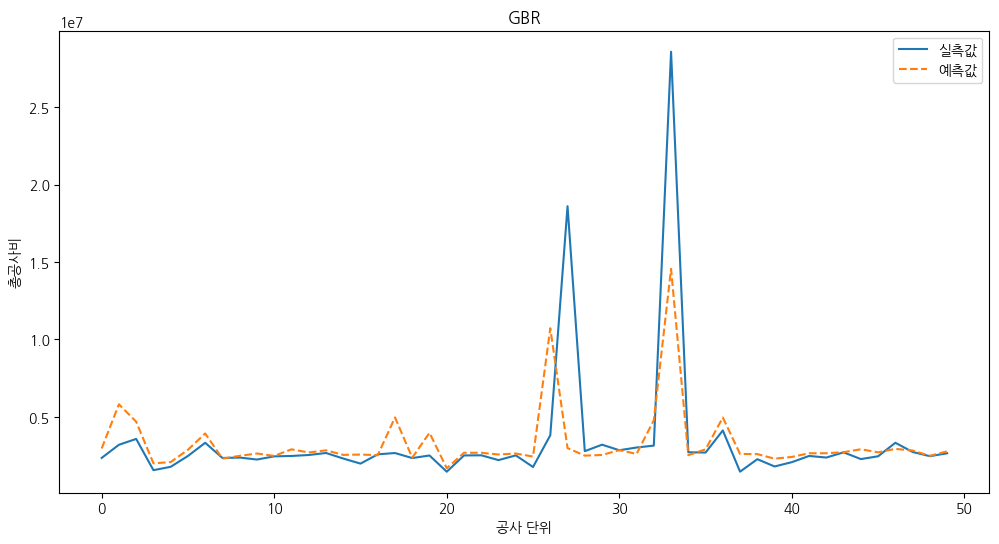

Evaluation: EN
R2_SCORE: 0.433259, MAPE: 20.184540, MSE: 3291965510055.688965, RMSE: 1814377.444209, MAE: 804226.375276
`EN` object has no attribute `feature_importances_`


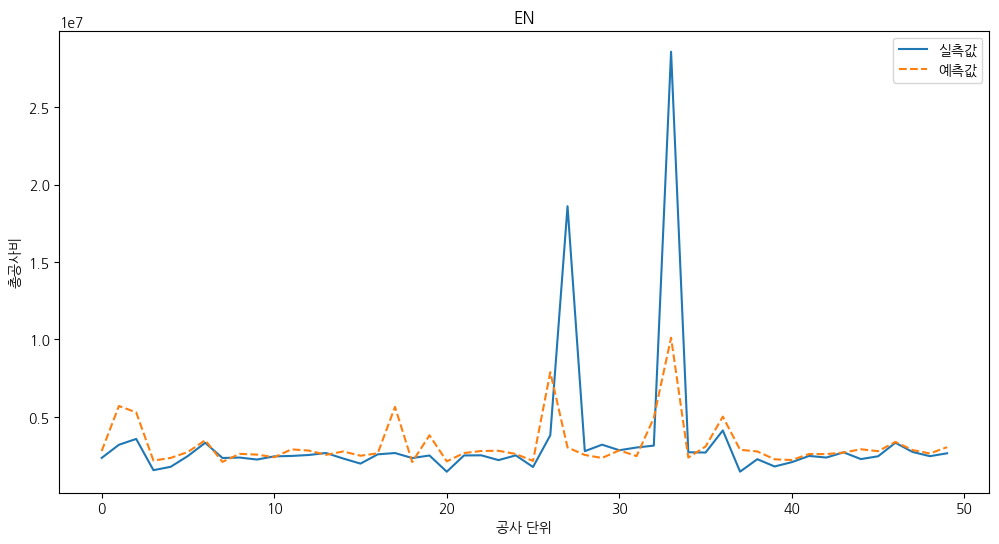

Evaluation: XGR
R2_SCORE: 0.020608, MAPE: 33.059950, MSE: 5688892804201.827148, RMSE: 2385139.996772, MAE: 1266424.057663


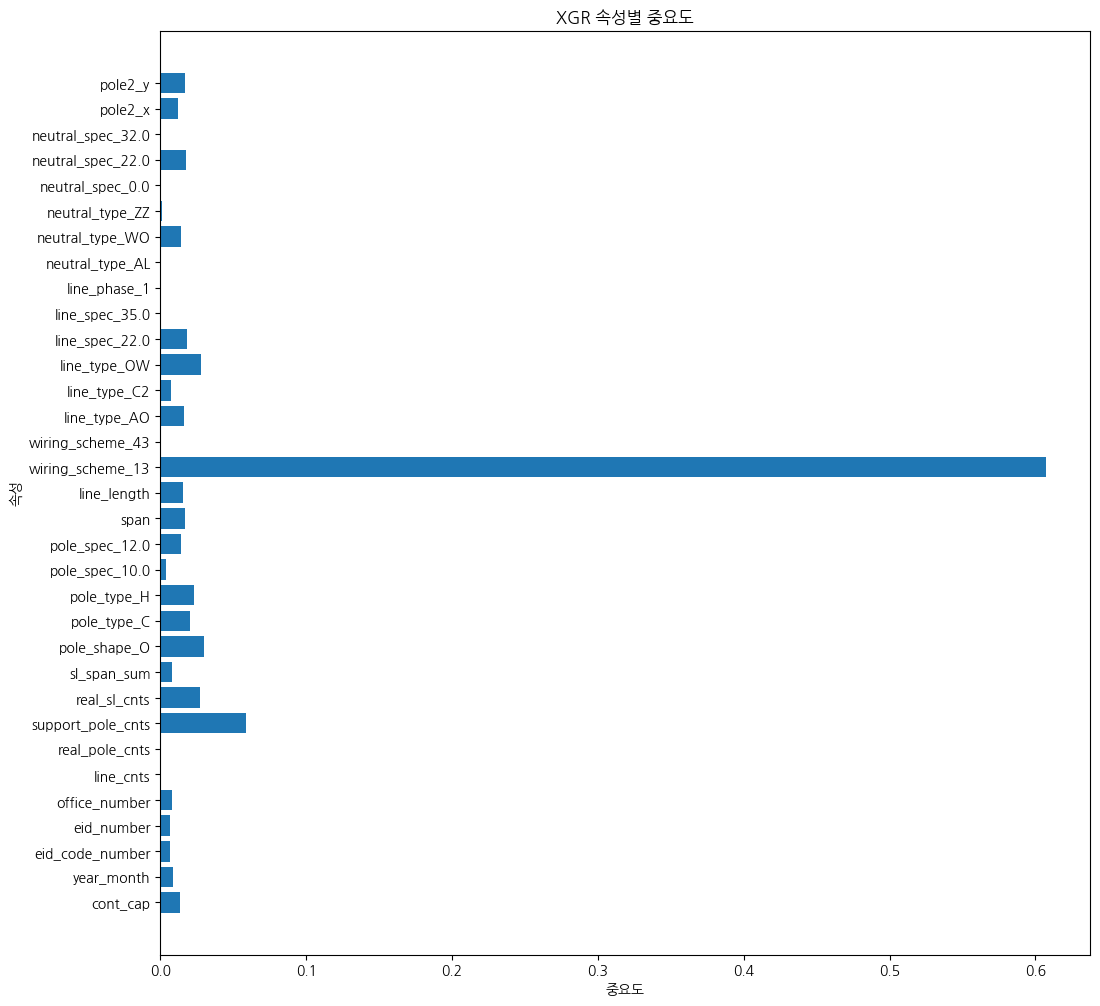

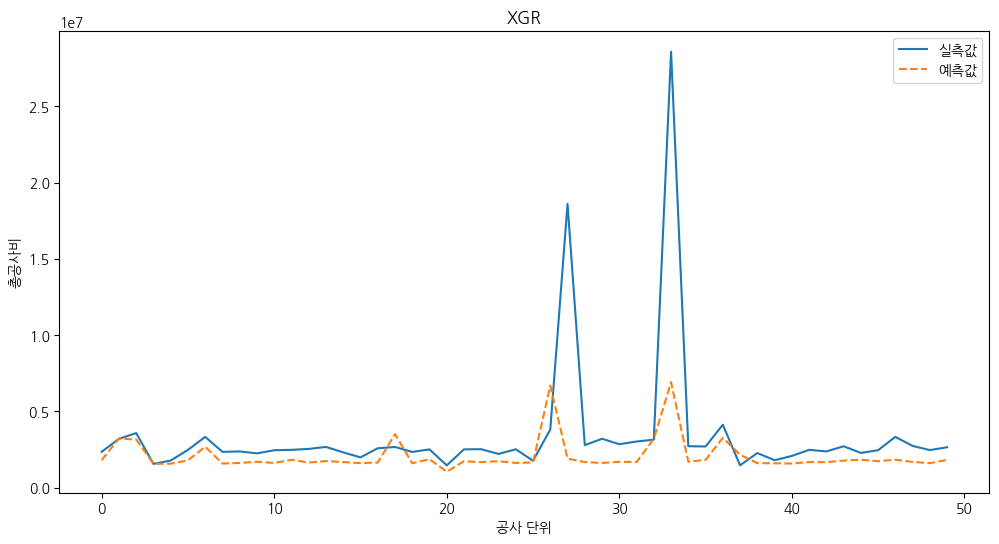

In [7]:
evaluation_values = []
model_names = []
column_names = ['r2score', 'mape', 'mse', 'rmse', 'mae']
for _model_key in ml_models.keys():
    model_fit_and_evaluation(_model_key, display_start=50, display_size=50)
    
df_evaluation = pd.DataFrame(
    evaluation_values, columns=column_names, index=model_names
)

In [8]:
df_evaluation

,r2score,mape,mse,rmse,mae
LIN,0.436293,0.201228,3.274344e+12,1.809515e+06,8.095649e+05
LASSO,0.436328,0.201223,3.274141e+12,1.809459e+06,8.095378e+05
RIDGE,0.436436,0.201199,3.273513e+12,1.809285e+06,8.094507e+05
KNR,0.339765,0.195786,3.835035e+12,1.958325e+06,8.216733e+05
DTR,-0.065211,0.246552,6.187377e+12,2.487444e+06,9.962358e+05
RFR,0.379955,0.201973,3.601587e+12,1.897785e+06,8.269959e+05
GBR,0.421536,0.191461,3.360064e+12,1.833048e+06,7.863190e+05
EN,0.433259,0.201845,3.291966e+12,1.814377e+06,8.042264e+05
XGR,0.020608,0.330600,5.688893e+12,2.385140e+06,1.266424e+06
